In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)


tf.random.set_seed(1234)


(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [2]:



model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)



Epoch 1/6
469/469 [==============================] - 3s 2ms/step - loss: 0.3680 - sparse_categorical_accuracy: 0.8976 - val_loss: 0.2063 - val_sparse_categorical_accuracy: 0.9401
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.1443 - val_sparse_categorical_accuracy: 0.9564
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9653 - val_loss: 0.1160 - val_sparse_categorical_accuracy: 0.9649
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0949 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.1036 - val_sparse_categorical_accuracy: 0.9699
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.0890 - val_sparse_categorical_accuracy: 0.9735
Epoch 6/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0642 - sparse_categorical_accu

In [28]:

f = open("raw_weights.txt", "w")
for layer in model.layers[1:]:
    f.write(layer.name)
    f.write("\n")
    f.write("Weight Shape:\n")
    f.write(str(layer.get_weights()[0].shape))
    f.write("\n")
    f.write("Bias Shape:\n")
    f.write(str(layer.get_weights()[1].shape))
    f.write("\n")
    f.write("weights:\n")
    f.write(str(layer.get_weights()[0]))
    f.write("\n")
    f.write("biases:\n")
    f.write(str(layer.get_weights()[1]))
    f.write("\n")
    f.write("\n")
f.close()

f = open("clean_weights.txt", "w")
for layer in model.layers[1:]:
    f.write(layer.name)
    f.write("\n")
    f.write("Weight Shape:\n")
    f.write(str(layer.get_weights()[0].shape))
    f.write("\n")
    f.write("Bias Shape:\n")
    f.write(str(layer.get_weights()[1].shape))
    f.write("\n")

    f.write("weights:\n")
    weights = layer.get_weights()[0]
    weights = weights * 256
    weights = weights.astype(int)

    f.write("(")
    for i in range(weights.shape[0]):
        f.write("(")
        for j in range(weights.shape[1]):
            f.write("\"" + bin(weights[i, j] & 0b111111111111111111)[2:].zfill(18) + "\",")
        f.write("),\n")
    f.write(")")


    
    f.write("biases:\n")
    bias = layer.get_weights()[1]
    bias = bias * 256
    bias = bias.astype(int)
    f.write("(")
    for i in range(bias.shape[0]):
        f.write("\"" + bin(bias[i] & 0b111111111111111111)[2:].zfill(18) + "\",")
        
    f.write(")")
    f.write("\n")
f.close()



Demonstration

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

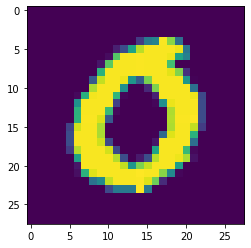

In [6]:
image = x_train[8000]
plt.imshow(image)

In [7]:
print(model.predict(np.array([image/255])))

[[ 15.058198   -11.97197      0.64760554  -2.1283774   -3.2877913
   -5.4364734   -1.9440724   -4.787583    -4.7576942    5.4049263 ]]


In [8]:
image = (image / 255 ) * 256
image = image.flatten().astype(int)

In [19]:
with open("image.txt", "w") as f:
    f.write("(")
    for i in range(len(image)):
        f.write("\"" + bin(image[i] & 0b111111111111111111)[2:].zfill(18) + "\",")
    f.write(")")

In [10]:
intermediate_weights = (model.layers[1].get_weights()[0] * 256).astype(int)
intermediate_output = (model.layers[1].get_weights()[1] * 256).astype(int)

final_weights = (model.layers[2].get_weights()[0] * 256).astype(int)
final_output = (model.layers[2].get_weights()[1] * 256).astype(int)

In [11]:
intermediate_output = ((np.matmul(image, intermediate_weights) + intermediate_output)/256).astype(int)
intermediate_output[intermediate_output < 0] = 0

In [12]:
final_output = ((np.matmul(intermediate_output, final_weights) + final_output)/256).astype(int)

In [13]:
(final_output/256).astype(int)

array([ 14, -11,   0,  -1,  -3,  -5,  -1,  -4,  -4,   5])

In [14]:
print(intermediate_output)

[   0 1699    0  356    0  179  892    0    0 1049    0    0  446    0
  127  438    0  620    0  225    0  467 1797    0  429  339    0  362
    0    0    0    4  762    0    0    0    0    0    0  199  299    0
    0    0 1290    0    0    0 1016   27  276  594  838   27    0   19
    0  855 1679    0  789    0  387  245    0 1504    0  752    0  236
  446   14    0    0   93    0  794  707  401  272    0  781  370    0
  377    0    0    0   14    0    0  565    0  726  262    0    0  430
    0  338  567  333  868  300    0  610    0    0    0  270    0 1660
  873    0  158 1087  293  227    0  236   60    0    0    0    0  878
    0  279]
